# Kidney Stone Classication using CT_Images

## Importing Libraries

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2 
from skimage.feature import hog 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import gradio as gr

## Preparing Traning Data

In [37]:
folder_path = "C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [38]:
df.head()

,filename,category
0,Normal\Normal- (1).jpg,Normal
1,Normal\Normal- (10).jpg,Normal
2,Normal\Normal- (100).jpg,Normal
3,Normal\Normal- (1000).jpg,Normal
4,Normal\Normal- (101).jpg,Normal


In [39]:
df.tail()

,filename,category
2995,Stone\Stone- (995).jpg,Stone
2996,Stone\Stone- (996).jpg,Stone
2997,Stone\Stone- (997).jpg,Stone
2998,Stone\Stone- (998).jpg,Stone
2999,Stone\Stone- (999).jpg,Stone


<Axes: xlabel='category'>

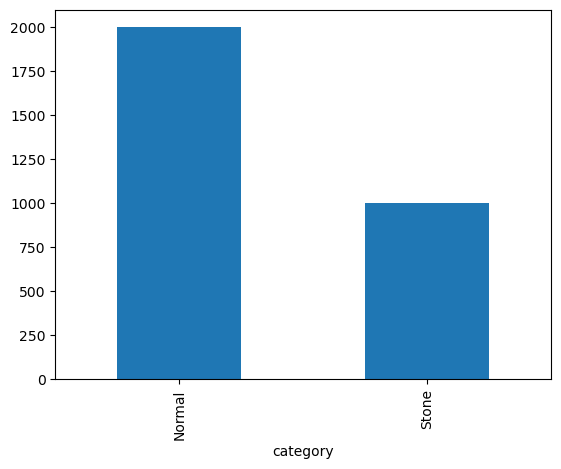

In [40]:
df['category'].value_counts().plot.bar()

We have 3000 total images (2000 Normal, 1000 Stone)

## Visualizing Data

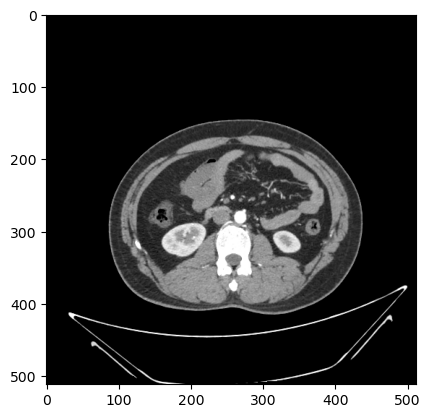

In [41]:
sample = random.choice(filenames)
image_path = "C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train\\" + sample
image = load_img(image_path)
plt.imshow(image)

# CNN(Convolutional Neural Network)

## Building CNN Model

In [42]:
model = Sequential()

#Adding convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2
model.add(Activation('sigmoid')) #sigmoid for binary class classification

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

### Call Backs

#### Early Stop
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [44]:
earlystop = EarlyStopping(patience=10)

#### Learning Rate Reduction
We will reduce the learning rate when then accuracy not increase for 2 steps

In [45]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [46]:
callbacks = [earlystop, learning_rate_reduction]

### Preparing Data

In [47]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

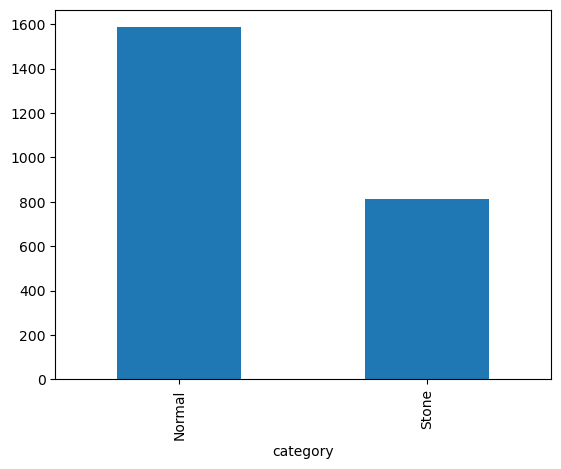

In [48]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

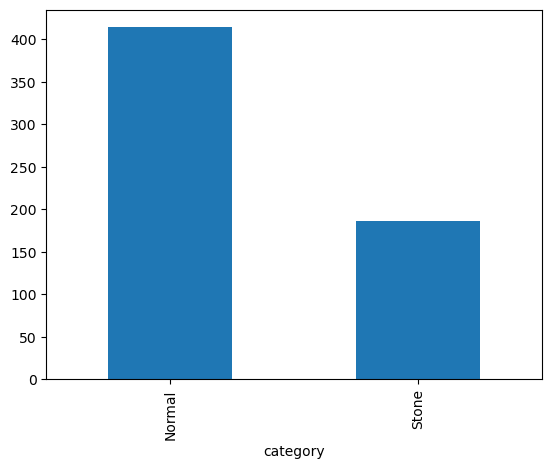

In [49]:
validate_df['category'].value_counts().plot.bar()

### Train and Validation generator

In [50]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [51]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


### Visulaizing the output of data gen

In [52]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


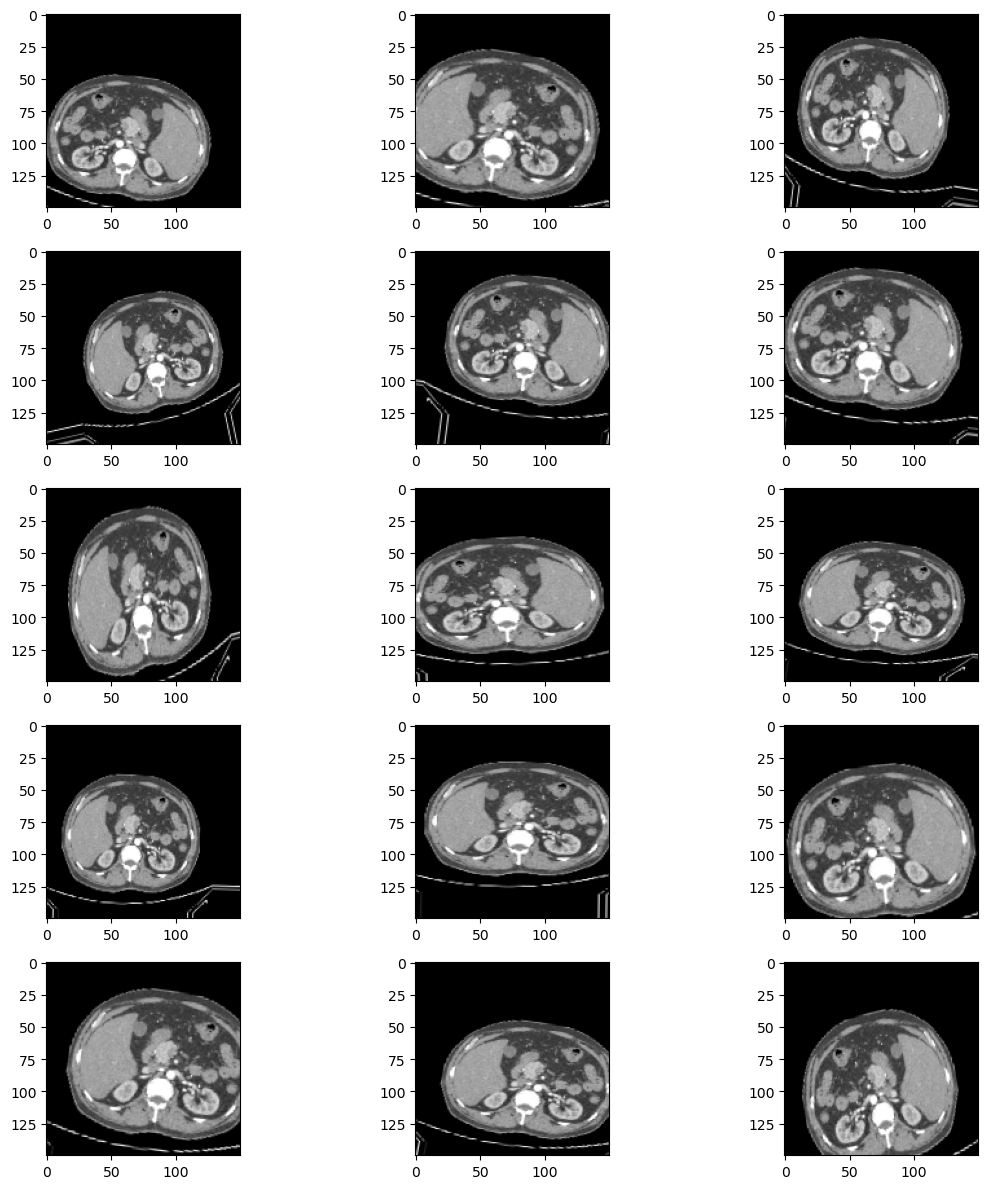

In [53]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fitting the Model

In [54]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [55]:
history = model.fit(
    train_generator, 
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

Epoch 1/25


C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 387ms/step - accuracy: 0.7321 - loss: 0.7299 - val_accuracy: 0.4950 - val_loss: 1.4548 - learning_rate: 0.0010
Epoch 2/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25


C:\Users\Student\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


160/160 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - accuracy: 0.8533 - loss: 0.3805 - val_accuracy: 0.7717 - val_loss: 0.4866 - learning_rate: 0.0010
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 159us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - accuracy: 0.8620 - loss: 0.3537 - val_accuracy: 0.8600 - val_loss: 0.3071 - learning_rate: 0.0010
Epoch 6/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 148us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8674 - loss: 0.3155
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 299ms/step - accuracy: 0.8675 - loss: 0.3154 - val_accuracy: 0.7800 - val_loss: 0.7227 - learning_rate: 0.0010
Epoch 8/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 163us/step

### Visualizing the Training history

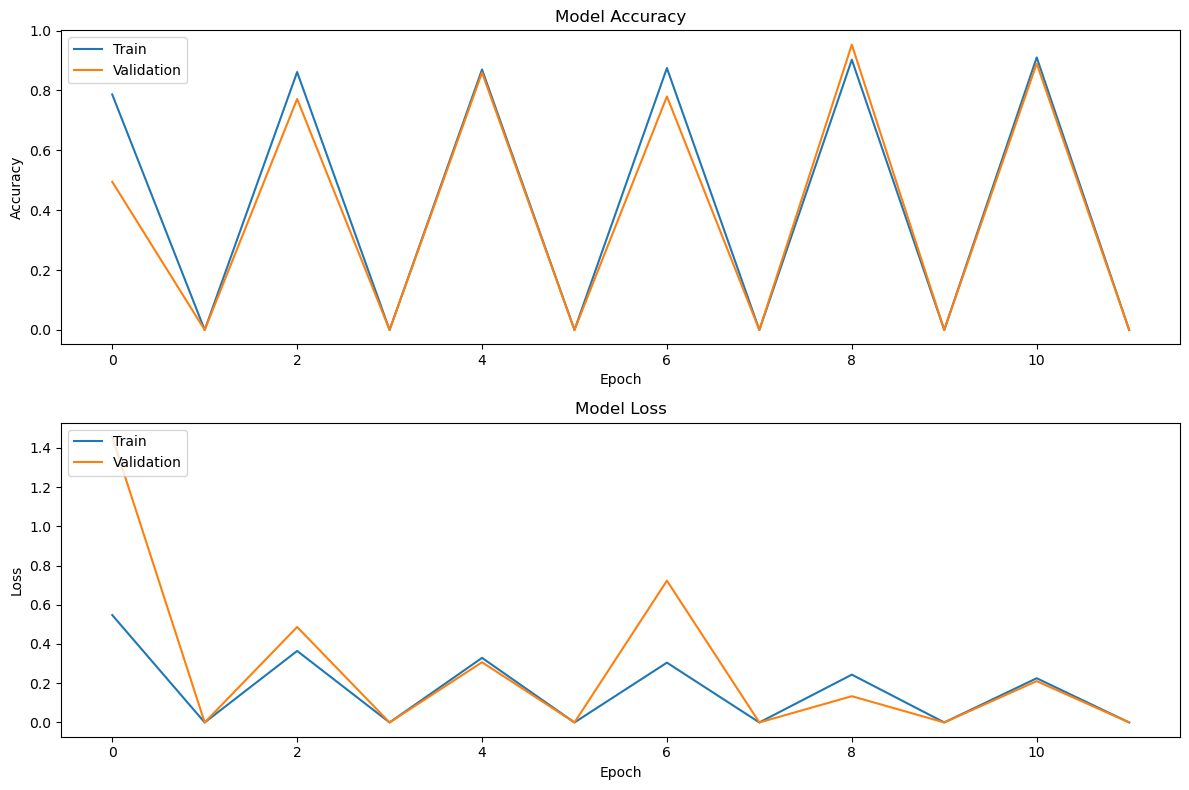

In [56]:
# Plotting the training history
plt.figure(figsize=(12, 8)) 

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Saving the CNN Model

In [57]:
# Saving the Model
model.save('kidney_stone_detection_model.h5')

### Testing Data

In [58]:
test_folder_path = "C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)
    
    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [59]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Test", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 900 validated image filenames belonging to 2 classes.


### Predictions

In [60]:
steps = int(np.ceil(test_df.shape[0] / 15))
predict = model.predict(test_generator, steps=steps)


 1/60 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step


In [61]:
test_df['predicted category'] = np.argmax(predict, axis=-1)

In [62]:
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [63]:
test_df.head()

,filename,category,predicted category
0,Normal\Normal- (1001).jpg,Normal,Normal
1,Normal\Normal- (1002).jpg,Normal,Normal
2,Normal\Normal- (1003).jpg,Normal,Normal
3,Normal\Normal- (1004).jpg,Normal,Normal
4,Normal\Normal- (1005).jpg,Normal,Normal


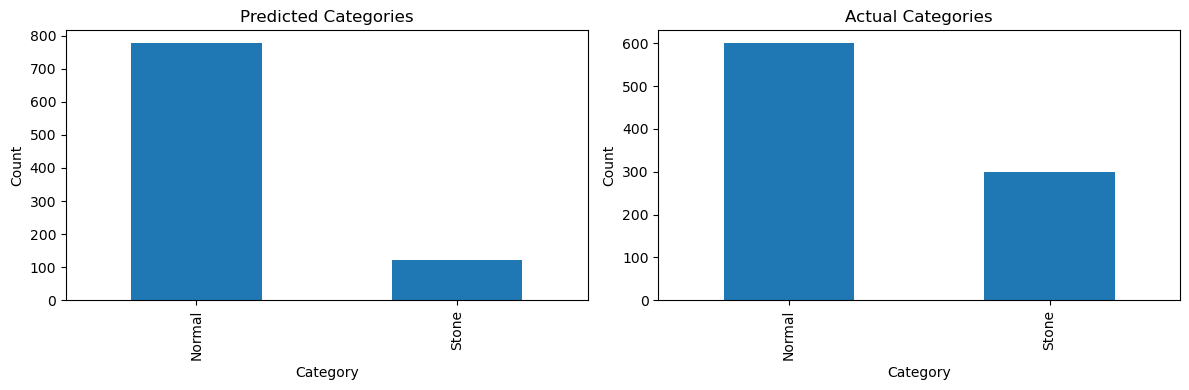

In [64]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

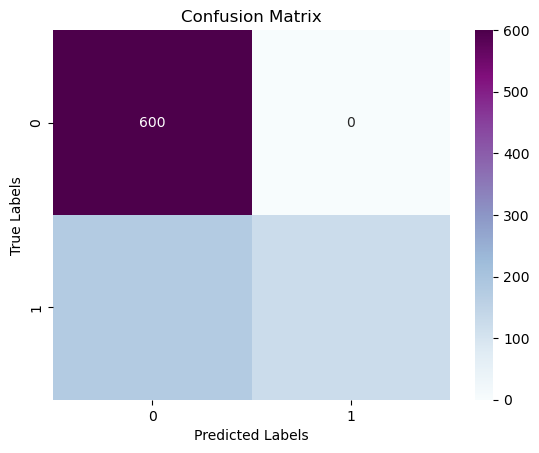

In [65]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

The results is baised toward normal as we have more Normal Images 

In [66]:
model.evaluate(test_generator)

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9671 - loss: 0.0835


[0.5317338109016418, 0.8033333420753479]

# SVM

In [67]:
#Defining a function to read images from the train and test folders
def read_images(path):
    images_list = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images_list.append(img)
    return images_list

In [68]:
#Reading train images from the normal and stone folders
train_normal = read_images('C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train\\Normal')
train_stone = read_images('C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Train\\Stone')

In [69]:
#Creating a list of labels for training 
labels = ['Normal' for item in train_normal] + ['Stone' for item in train_stone]

In [70]:
#Defining a function for HOG feature extraction
def extract_features(images):
    feature_list = []
    for img in images:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), 
                            cells_per_block=(1, 1), visualize=True, channel_axis=2)
        # Resize the HOG features to a fixed size
        fd = np.resize(fd, (2400, 1))
        # Flatten the array to 2 dimensions
        fd = fd.flatten()
        feature_list.append(fd)
    return feature_list

In [71]:
#Extracting the HOG features from both normal and stone images
feature_list_normal = extract_features(train_normal)
feature_list_stone = extract_features(train_stone)

In [72]:
print(len(feature_list_normal))
print(len(feature_list_stone))

2000
1000


In [73]:
#Combining the features for both classes
features = feature_list_normal + feature_list_stone

In [74]:
#Reading test images from the normal and stone folders
test_normal = read_images('C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Test\\Normal')
test_stone = read_images('C:\\Users\\Student\\Downloads\\Kidney-Stone-Detection-main\\Kidney-Stone-Detection-main\\CT_images\\Test\\Stone')

In [75]:
#Creating a list of labels for testing 
test_labels = ['Normal' for item in test_normal] + ['Stone' for item in test_stone]

In [76]:
#Creating a Feature Vector for Test Set
test_feature_list_normal = extract_features(test_normal)
test_feature_list_stone = extract_features(test_stone)

In [77]:
print(len(test_feature_list_normal))
print(len(test_feature_list_stone))

600
300


In [78]:
#Combining the features for both classes
test_features = test_feature_list_normal + test_feature_list_stone

In [79]:
#Splitting the data into train and valid sets
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=0)

In [80]:
# Print the shape of the first element in the X_train array
print(X_train[0].shape)

# Print the shape of the second element in the X_train array
print(X_train[1].shape)

# Print the shape of the last element in the X_train array
print(X_train[-1].shape)

(2400,)
(2400,)
(2400,)


In [81]:
# Training a SVM Model
svc = SVC(kernel='rbf', C=1, gamma='auto')
svc.fit(X_train, y_train)

SVC(C=1, gamma='auto')

In [82]:
# Predicting the Test Set
y_pred = svc.predict(X_valid)

In [83]:
#Calculating the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.7966666666666666


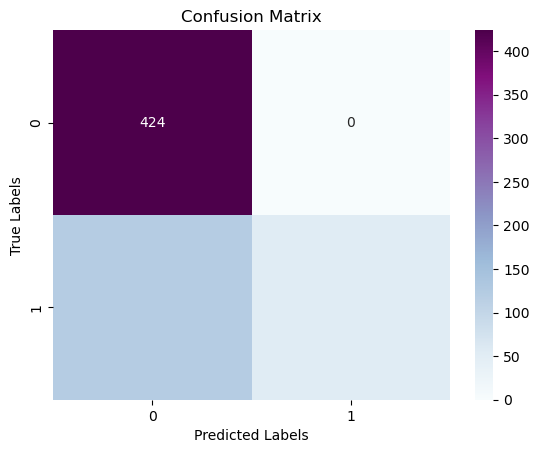

In [84]:
svm_cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

Same case is with the SVM it is also baised towrads the Normal 

In [85]:
import sklearn.externals
import joblib

# Save the model to a file
joblib.dump(svc, 'svc.pkl')

['svc.pkl']

# GUI

## If you dont want to train the models you can load the models which I have already trained otherwise you can skip these loading models cell and directly run the GUI

In [86]:
from keras.models import load_model
model = load_model('kidney_stone_detection_model.h5')

In [87]:
import sklearn.externals
import joblib
svc = joblib.load("svc.pkl") 

## Custom tkinter GUI  

## Gradio APP

In [101]:
import numpy as np
import keras.utils as image
import gradio as gr
from keras.models import load_model

# Load the trained model
model = load_model("kidney_stone_detection_model.h5")

def custom_Image_preprocessing(image_data, target_size=(150, 150)):
    img = image.array_to_img(image_data, data_format='channels_last')
    img = img.resize(target_size)  # Resize the image if needed
    img_arr = image.img_to_array(img)
    img_arr = img_arr * 1./255
    img_arr = np.expand_dims(img_arr, axis=0)
    return img_arr

def predict(img):
    image_preprocess = custom_Image_preprocessing(img)
    result = model.predict(image_preprocess)
    print(result[0][0])
    if result[0][0] > 0.5:
        return 'No Kidney Stone Detected (Negative)', round(result[0][0]*100, 2), '%'
    else:
        return 'Kidney Stone Detected (Positive)', round(result[0][0]*100, 2), '%'

# Create a Gradio interface
input_component =  gr.components.Image(label = "Upload the CT-Image")
output_component = gr.components.Textbox(label = "Prediction")

iface = gr.Interface(
    fn=predict,
    inputs=input_component, 
    outputs=output_component,
    title = "Kidney Stone Classification",
    description="This web app provides predictions based on CT-images and predicts whether the CT-Scan contains symptoms of Kidney stone or not."
)

iface.launch()


Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
0.99861205


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\Student\anaconda3\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 411, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Student\anaconda3\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 69, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Student\anaconda3\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\Student\anaconda3\Lib\site-packages\starlette\applications.py", line 123, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\Student\anaconda3\Lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "C:\Users\Student\anaconda3\Lib\site-packa

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.030166602
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0.99408734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.30315593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.44011983
